In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, precision_recall_fscore_support

from models.MeTooDataset import MeTooDataset

In [2]:
labels = ['Against', 'Neutral', 'Favor']

In [3]:
experiment_name = '1E'

In [4]:
algorithm_name = 'boc'

In [5]:
profile_ids = [783214, 19568591, 103018203, 256881576, 810619093749559296]

In [6]:
labels=list('ABDEF')

# Training Setup

In [7]:
training_dataset = MeTooDataset(
    root='/home/nils/Documents/thesis/data/',
    mode='word_embeddings',
    task='metoo_training')

In [8]:
testing_dataset = MeTooDataset(
    root='/home/nils/Documents/thesis/data/',
    mode='word_embeddings',
    task='metoo_testing')

In [9]:
vectorizer = TfidfVectorizer()

In [10]:
corpus = [
    *[" ".join([str(elem.item()) for elem in tensor]) for tensor in training_dataset.X],
    *[" ".join([str(elem.item()) for elem in tensor]) for tensor in testing_dataset.X]
]

In [11]:
X = vectorizer.fit_transform(corpus)

In [12]:
svm = LinearSVC(
    max_iter=10000, 
    verbose=1
)

# Training

In [13]:
svm.fit(
    X[:len(training_dataset.X)],
    training_dataset.y
)

[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=1)

# Testing

In [14]:
predictions = svm.predict(X[len(training_dataset.X):])

In [15]:
df = pd.DataFrame.from_records(
        precision_recall_fscore_support(
            testing_dataset.y, 
            predictions
        )[:3], 
        index=['Precision', 'Recall', 'F1-Score'], 
        columns=[labels[idx] for idx in set(testing_dataset.y)]
    ).transpose()

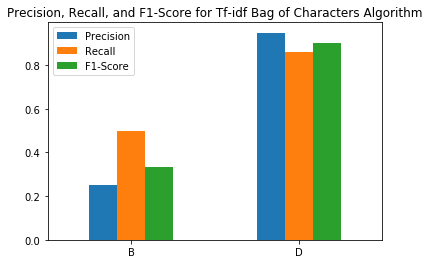

In [16]:
df.plot(kind='bar', title=f'Precision, Recall, and F1-Score for Tf-idf Bag of Characters Algorithm', legend=True, rot=0)
plt.legend(loc='upper left')

with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/img/{experiment_name}_{algorithm_name}.eps', 'wb') as f:
    plt.savefig(f, format='eps')

In [17]:
with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/data/{experiment_name}_{algorithm_name}.tex', 'w', encoding='utf-8') as f:
    df.to_latex(f)

# Compute Stances based on Predictions

In [18]:
stances_df = pd.DataFrame.from_dict(
    {
        user_id: {
            'Stance': np.mean([
                stance
                for _user_id, stance in list(zip(testing_dataset.id, predictions))
                if _user_id == user_id
            ]
            )
        }
        for user_id in profile_ids
    },
    orient='index'
).applymap(lambda x: x-1)

In [19]:
with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/data/{experiment_name}_{algorithm_name}_stances.tex', 'w', encoding='utf-8') as f:
    stances_df.to_latex(f)

# Compute Means of annotated Stances

In [20]:
means_df = pd.DataFrame.from_dict(
    {
        user_id: {
            'Mean': np.mean(
                [
                    stance
                    for _user_id, stance in list(zip(testing_dataset.id, testing_dataset.y))
                    if _user_id == user_id
                ]
            )
        }
        for user_id in profile_ids
    },
    orient='index'
).applymap(lambda x: x - 1)

# Compute Mean Squared Error w.r.t. Means of Stances

In [21]:
mse_df = pd.DataFrame.from_dict(
    {
        user_id: {
            'Mean Squared Error': mean_squared_error(
                stances_df.loc[user_id].values,
                means_df.loc[user_id].values
            )
        }
        for user_id in profile_ids
    },
    orient='index'
)

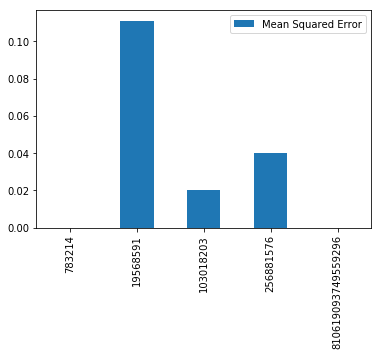

In [22]:
mse_df.plot(kind='bar')

In [23]:
with open(f'/home/nils/Documents/thesis/thesis-writing/thesis/data/{experiment_name}_{algorithm_name}_mse.tex', 'w', encoding='utf-8') as f:
    mse_df.to_latex(f)

In [25]:
with open(f'/home/nils/Documents/thesis/data/{experiment_name}_{algorithm_name}_mse.csv', 'w', encoding='utf-8') as f:
    mse_df.to_csv(f)